In [ ]:
import pandas as pd
data = pd.read_excel("cleaned-data.xlsx")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392431 entries, 0 to 392430
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392431 non-null  int64         
 1   StockCode    392431 non-null  object        
 2   Description  392431 non-null  object        
 3   Quantity     392431 non-null  int64         
 4   InvoiceDate  392431 non-null  datetime64[ns]
 5   Time         392431 non-null  object        
 6   UnitPrice    392431 non-null  float64       
 7   CustomerID   392431 non-null  int64         
 8   Country      392431 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 26.9+ MB


In [11]:
# Extract the hour from the Time column
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.time
data['Hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour
print(data['Hour'].value_counts().sort_index())

Hour
6         1
7       379
8      8688
9     21913
10    37728
11    48373
12    70923
13    62992
14    53260
15    44737
16    23587
17    12942
18     2896
19     3234
20      778
Name: count, dtype: int64


In [7]:
# Convert InvoiceDate to datetime (if not already done)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Define a reference date (e.g., one day after the last transaction in the dataset)
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
# Calculate Recency: Days since the customer's last purchase
rfm_recency = data.groupby('CustomerID')['InvoiceDate'].max().reset_index()
rfm_recency['Recency'] = (reference_date - rfm_recency['InvoiceDate']).dt.days

print("Recency Calculated:")
print(rfm_recency.head())

Recency Calculated:
   CustomerID InvoiceDate  Recency
0       12346  2011-01-18      326
1       12347  2011-12-07        3
2       12348  2011-09-25       76
3       12349  2011-11-21       19
4       12350  2011-02-02      311


In [8]:
# Count the number of unique transactions per customer
rfm_frequency = data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
rfm_frequency.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

print("Frequency Calculated:")
print(rfm_frequency.head())


Frequency Calculated:
   CustomerID  Frequency
0       12346          1
1       12347          7
2       12348          4
3       12349          1
4       12350          1


In [9]:
# Calculate the total monetary value for each customer
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
rfm_monetary = data.groupby('CustomerID')['TotalPrice'].sum().reset_index()
rfm_monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

print("Monetary Value Calculated:")
print(rfm_monetary.head())


Monetary Value Calculated:
   CustomerID  Monetary
0       12346  77183.60
1       12347   4310.00
2       12348   1797.24
3       12349   1757.55
4       12350    334.40


In [10]:
# Merge all RFM components
rfm = rfm_recency.merge(rfm_frequency, on='CustomerID').merge(rfm_monetary, on='CustomerID')

print("Combined RFM Table:")
print(rfm.head())


Combined RFM Table:
   CustomerID InvoiceDate  Recency  Frequency  Monetary
0       12346  2011-01-18      326          1  77183.60
1       12347  2011-12-07        3          7   4310.00
2       12348  2011-09-25       76          4   1797.24
3       12349  2011-11-21       19          1   1757.55
4       12350  2011-02-02      311          1    334.40


In [12]:
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Time,UnitPrice,CustomerID,Country,TotalPrice,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,08:26:00,2.55,17850,United Kingdom,15.30,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,08:26:00,3.39,17850,United Kingdom,20.34,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,08:26:00,2.75,17850,United Kingdom,22.00,8


In [13]:
# Define quantiles for scoring
quantiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([0.2, 0.4, 0.6, 0.8]).to_dict()

def rfm_score(value, metric):
    if value <= quantiles[metric][0.2]:
        return 5
    elif value <= quantiles[metric][0.4]:
        return 4
    elif value <= quantiles[metric][0.6]:
        return 3
    elif value <= quantiles[metric][0.8]:
        return 2
    else:
        return 1

# Apply scoring
rfm['Recency_Score'] = rfm['Recency'].apply(rfm_score, metric='Recency')
rfm['Frequency_Score'] = rfm['Frequency'].apply(rfm_score, metric='Frequency')
rfm['Monetary_Score'] = rfm['Monetary'].apply(rfm_score, metric='Monetary')

# Combine into an RFM Score
rfm['RFM_Score'] = rfm['Recency_Score'].astype(str) + rfm['Frequency_Score'].astype(str) + rfm['Monetary_Score'].astype(str)


In [17]:
def segment_customer(row):
    if row['RFM_Score'] == '555':
        return 'Best Customers'
    elif row['Recency_Score'] >= 4 and row['Frequency_Score'] <= 2:
        return 'At Risk'
    elif row['Frequency_Score'] >= 4:
        return 'Loyal Customers'
    elif row['Recency_Score'] <= 2:
        return 'Churned Customers'
    elif row['Monetary_Score'] >= 4:
        return 'Big Spenders'
    elif row['Recency_Score'] >= 365:  # Lost customers
        return 'Lost Customers'
    return 'Other'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
print(rfm['Segment'].value_counts())


Segment
Loyal Customers      2289
At Risk              1028
Other                 534
Churned Customers     391
Big Spenders           56
Best Customers         36
Name: count, dtype: int64


C:\Users\Abdul Basit\AppData\Local\Temp\ipykernel_12492\2581458611.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')


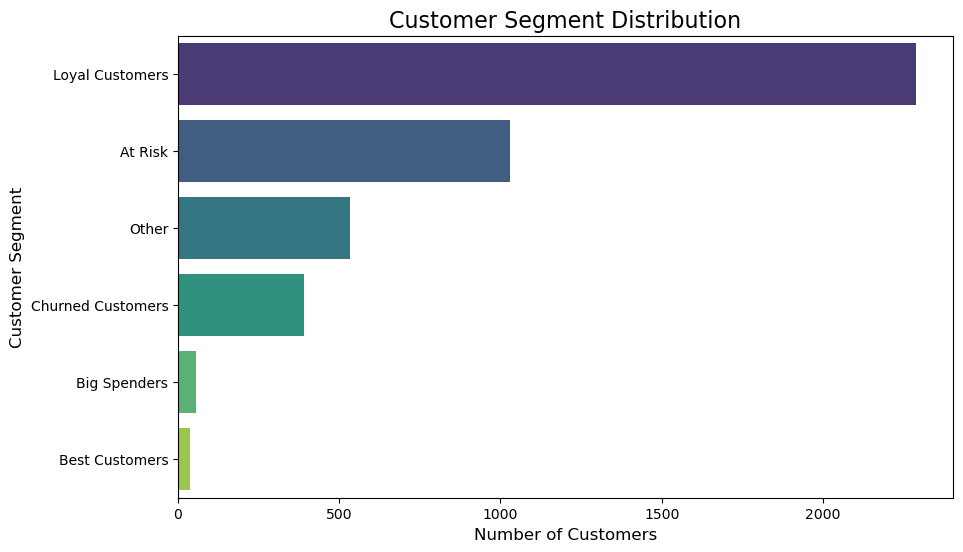

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize segment distribution as a bar chart
plt.figure(figsize=(10, 6))
sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Customer Segment Distribution', fontsize=16)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Customer Segment', fontsize=12)
plt.show()

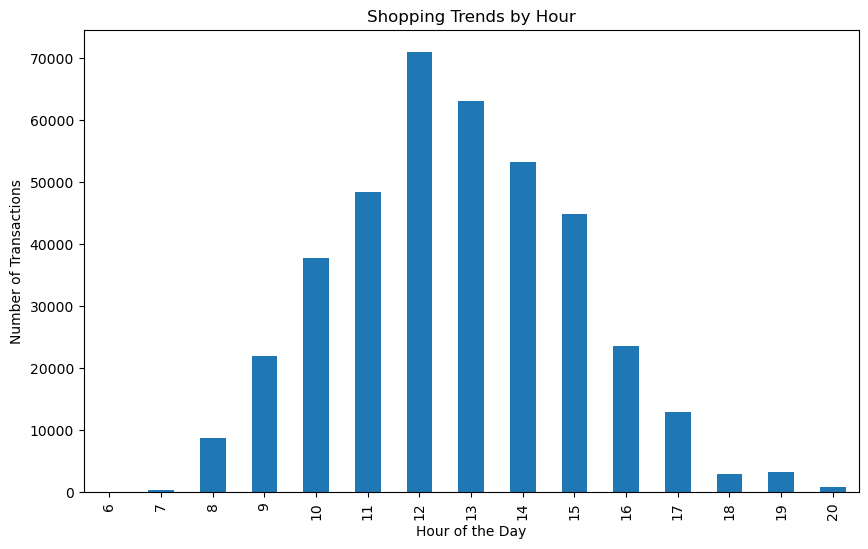

In [24]:
hourly_distribution = data['Hour'].value_counts().sort_index()
hourly_distribution.plot(kind='bar', figsize=(10, 6), title="Shopping Trends by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.show()


In [21]:
# Extract the month from the InvoiceDate to identify peak shopping months
data['Month'] = data['InvoiceDate'].dt.month

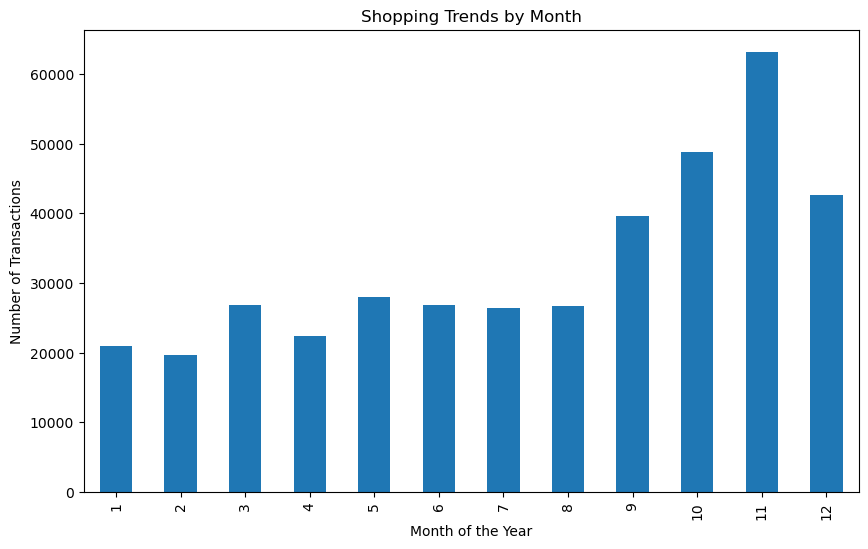

In [23]:
monthly_distribution = data['Month'].value_counts().sort_index()
monthly_distribution.plot(kind='bar', figsize=(10, 6), title="Shopping Trends by Month")
plt.xlabel("Month of the Year")
plt.ylabel("Number of Transactions")
plt.show()


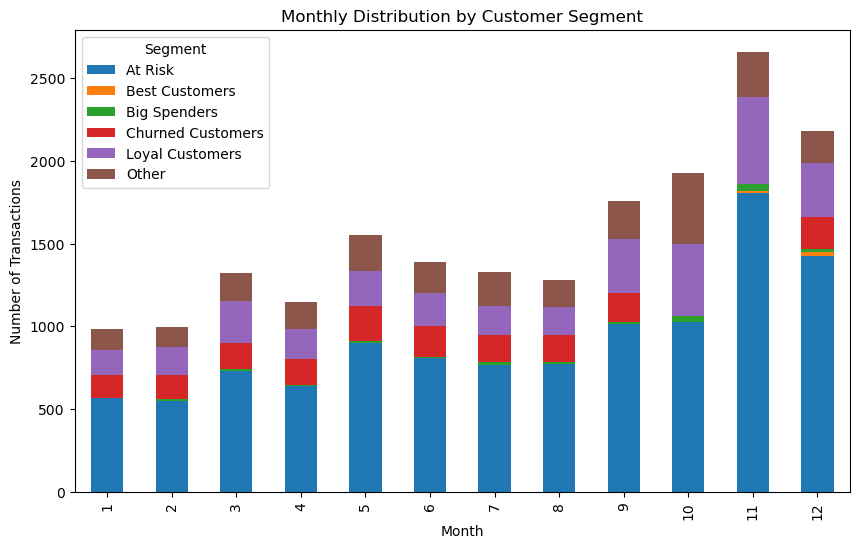

In [26]:
# Merge the 'Segment' column from the rfm DataFrame to the data DataFrame
data = data.merge(rfm[['CustomerID', 'Segment']], on='CustomerID', how='left')

# Now you can perform the grouping with 'Segment' and 'Month'
monthly_segment_distribution = data.groupby(['Month', 'Segment'])['InvoiceNo'].nunique().unstack().fillna(0)

# Plot the results
monthly_segment_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), title="Monthly Distribution by Customer Segment")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.show()

In [27]:
# Extract the weekday from InvoiceDate (0=Monday, 6=Sunday)
data['Weekday'] = data['InvoiceDate'].dt.weekday

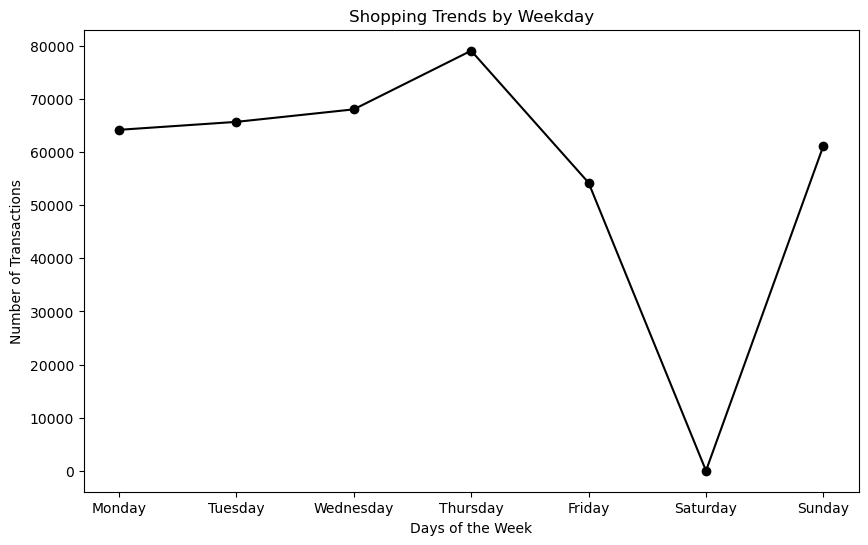

In [64]:

# Get the value counts for the weekdays (0=Monday, 6=Sunday)
weekday_distribution = data['Weekday'].value_counts().sort_index()

# Create a full week (0-6) with 0s for missing days
full_week = pd.Series(0, index=range(7))  # 7 days (0-6) filled with 0
weekday_distribution = full_week.add(weekday_distribution, fill_value=0)

# Plot the data
weekday_distribution.plot(kind='line', marker='o', color='black', markersize=6,figsize=(10, 6), title="Shopping Trends by Weekday")

# Manually set the x-ticks labels to include all weekdays (0-6)
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Add labels and title
plt.xlabel("Days of the Week")
plt.ylabel("Number of Transactions")
# Show the plot
plt.show()


In [49]:
# Filter the data for Saturday (weekday = 5)
saturday_data = data[data['Weekday'] == 5]

# Check the number of transactions on Saturday
print(f"Number of transactions on Saturday: {saturday_data.shape[0]}")
print(saturday_data.head())  # Optionally inspect a few rows to verify


Number of transactions on Saturday: 0
Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, Time, UnitPrice, CustomerID, Country, TotalPrice, Hour, Month, Segment, Weekday]
Index: []


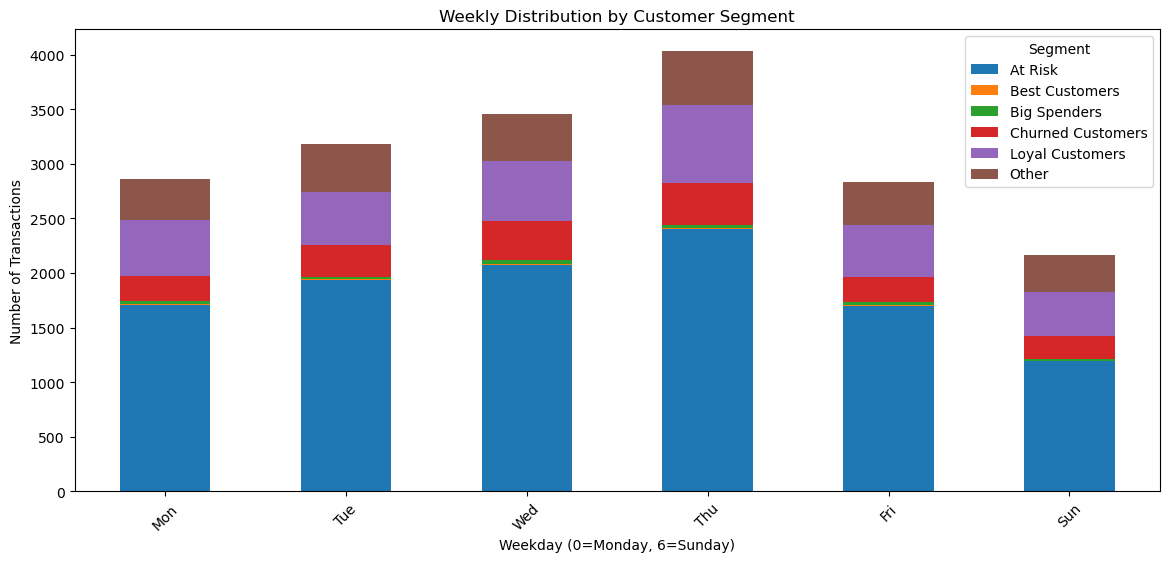

In [ ]:
# Group by 'Weekday' and 'Segment' and count the unique 'InvoiceNo'
weekly_segment_distribution = data.groupby(['Weekday', 'Segment'])['InvoiceNo'].nunique().unstack().fillna(0)

# Plot the results
weekly_segment_distribution.plot(kind='bar', stacked=True, figsize=(14, 6), title="Weekly Distribution by Customer Segment")
plt.xlabel("Weekday (0=Monday, 6=Sunday)")
plt.ylabel("Number of Transactions")
plt.xticks(ticks=range(6), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sun'], rotation=45)
plt.show()


In [65]:
data.to_excel('updated_customer_data.xlsx', index=False) 